In [ ]:
#!pip install -q llama-toolchain
# !llama model list
# !llama download --source meta --model-id "Meta-Llama3.1-8B" --meta-url "https://llama3-1.llamameta.net/*?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiY3hhdWRmem5kOXhya2lza3A3aGV0bnN3IiwiUmVzb3VyY2UiOiJodHRwczpcL1wvbGxhbWEzLTEubGxhbWFtZXRhLm5ldFwvKiIsIkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyNDE0NjgzM319fV19&Signature=GiocjWKNW%7E9xxZj6Os19-QGlsH6Sv6nbj657DlcN-djjJ5vRpuLOaOmJFlh8PMW-21K5MOIC1%7EQTD7MrpJ00sMan8VNrUuNsMIp4unrZPJYotOGfc9MHx7-zihEBap3YHh%7ETcVT72%7EW5yzwR4wV5d8gxIsi2eUpmM%7EvysTI48d5iVd7r3MPTzkQSuklE-tAWSlKVKxgP-cWh2j8FBcKl99aeTCjXmkzliQKw9kB0Bh9Hnze2BnCXqIO6P4OdbnCWBZAsCf8aBrPbOEc6y90uL48RKkfQLIq-yP%7EXeaagAE4sHi2OjqDwqtu8J5EoboZc65Bc8wZSeoxrcTqGOd4YyQ__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=1416263852379241"


https://github.com/naklecha/llama3-from-scratch/blob/main/llama3-from-scratch.ipynb


https://github.com/evintunador/minLlama3


https://github.com/Blaizzy/Coding-LLMs-from-scratch/blob/main/Llama-3/Part%201/Downcycling.ipynb

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cuda.enable_mem_efficient_sdp(True)
torch.backends.cuda.enable_flash_sdp(True)
device

device(type='cuda', index=0)

In [ ]:
!pip install -q sentencepiece tiktoken blobfile accelerate hf-transfer

# Inference

In [ ]:
import torch
from transformers import AutoModelForCausalLM,AutoTokenizer

model_id = "meta-llama/Meta-Llama-3-8B"

tokenizer = AutoTokenizer.from_pretrained(model_id)

model = AutoModelForCausalLM.from_pretrained(model_id,trust_remote_code=True,torch_dtype=torch.bfloat16,
                                      low_cpu_mem_usage=True,device_map="auto")

model.config


tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/177 [00:00<?, ?B/s]

LlamaConfig {
  "_name_or_path": "meta-llama/Meta-Llama-3-8B",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 8192,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 500000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.42.3",
  "use_cache": true,
  "vocab_size": 128256
}

In [ ]:
model.config.gradient_checkpointing = True  # reduce number of stored activations
model.config.use_cache = False  # disable cache for memory efficiency
model.config.output_hidden_states = True  # set to True if you want hidden states
model.config.output_attentions = True  # set to True if you want attention weights
model.config

LlamaConfig {
  "_name_or_path": "meta-llama/Meta-Llama-3-8B",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "gradient_checkpointing": true,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 8192,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "output_attentions": true,
  "output_hidden_states": true,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 500000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.42.3",
  "use_cache": false,
  "vocab_size": 128256
}

# Model Architecture
## AutoModel without Causal Head

        LlamaModel(
          (embed_tokens): Embedding(128256, 4096)
          (layers): ModuleList(
            (0-31): 32 x LlamaDecoderLayer(
              (self_attn): LlamaSdpaAttention(
                (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
                (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
                (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
                (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
                (rotary_emb): LlamaRotaryEmbedding()
              )
              (mlp): LlamaMLP(
                (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
                (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
                (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
                (act_fn): SiLU()
              )
              (input_layernorm): LlamaRMSNorm()
              (post_attention_layernorm): LlamaRMSNorm()
            )
          )
          (norm): LlamaRMSNorm()
        )
        
        
## now adding causal LM Head

    LlamaForCausalLM(
      (model): LlamaModel(...)
      (lm_head): Linear(in_features=4096, out_features=128256, bias=False)
    )
    
Here out_features = vocab_sz (128k)

"intermediate_size"= 3.5 *  "hidden_size" = 3.5 * 4096 = 14336 , design choice



## Inference with Alpaca style Prompt

```python

# {
#     "description": "Template used by Alpaca-LoRA.",
#     "prompt_input": "Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\n{instruction}\n\n### Input:\n{input}\n\n### Response:\n",
#     "prompt_no_input": "Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\n{instruction}\n\n### Response:\n",
#     "response_split": "### Response:"    
# }
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""
EOS_TOKEN = tokenizer.eos_token
def format_prompt(sample):
    instructions=sample["instruction"] # here system_prompt
    inputs = sample["input"]           # here user_prompt
    responses = sample["output"]        # here "" preset but will be in training dataset
    texts = []
    for instruction,input,response in zip(instructions,inputs,responses):
        text = alpaca_prompt.format(instruction,input,response)+EOS_TOKEN
        texts.append(text)
    return {"text":texts,} # add data in 1 column for SFTTrainer
    
from datasets import load_dataset
dataset = load_dataset("yahma/alpaca-cleaned",split="train")
dataset = dataset.map(format_prompt,batched=True)


def prepare_for_peft(model):
    for param in model.parameters():
        param.requires_grad = False  # freeze the model - train adapters later
        if param.dim() == 1:
            # cast the small parameters (e.g. layernorm) to fp32 for stability
            param.data = param.data.to(torch.float32)

    model.config.gradient_checkpointing = True  # enable gradient checkpointing
    model.config.use_cache = False  # disable cache for memory efficiency
    model.config.output_hidden_states = True  # set to True if you want hidden states
    model.config.output_attentions = True  # set to True if you want attention weights

    # No need to define a separate class, we can use nn.Sequential directly
    model.lm_head = nn.Sequential(nn.Linear(model.config.hidden_size, model.config.vocab_size))
    return model

```

In [ ]:

system_prompt = "You are an AI assistant knowledgeable in various fields."
user_prompt = "Tell me about continuous batching for faster inference in LLM"
output = ""

alpaca_prompt = f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{system_prompt}

### Input:
{user_prompt}

### Response:
{output}"""

# print(alpaca_prompt)

inputs = tokenizer(alpaca_prompt, return_tensors='pt',return_token_type_ids=False).to("cuda")

# Generate output
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        do_sample=True,
        temperature=0.7,
        top_p=0.95,
        top_k=40,
        max_new_tokens=512
    )

# Decode and print the output
output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Output:", output_text)

### Inference with Chat Template & Text Streamer

```python
inputs = tokenizer(
[
   "Who created Python?"
], return_tensors = "pt")

inputs = tokenizer.apply_chat_template(
    [
        # {"content":"","role":"system"},
        {"content":"""Given the question: Read the article and select the best
         answer. Article: Can you swim? Do you like swimming? Well, how can you
         learn to swim? I think the best way is to go into the water and learn.
        I'm afraid you'll never learn to swim just by reading books about
        Swimming or looking at others swimming. It's the same with the English
        study. We must practice, practice and practice. Listening and speaking
        are very important for beginners. We can listen to English programs on radio.
        You may just understand a few words. It doesn't matter. Just be relaxed,
        try to catch every word. Somebody may be a good listener, but he is afraid
        to speak because he's afraid of making mistakes. You know we sometimes
        make mistakes when we speak Chinese. Don't be afraid. We must be brave.
        If you really want to learn English well, you must try to speak with
        everyone as long as he knows English. When there's nobody to talk with,
        you can talk to yourself in English. It's interesting and also a good
        way to practice your spoken English. Remember, the more you speak, the
        fewer mistakes you'll make. Reading and writing are more important for
        senior school students. First we must choose the books we're interested
        in. A lot of reading will improve your language sense.
        This is very important. It's easier said than done. Well, let's do
        more practice from now on. I'm sure you'll learn English well in this
        way. ,A, B, C, D,. (10)
        Question: Which is the best title for the passage?
        Options:
            A: How to Learn English.
            B: Easier Said Than Done.
            C: Listen First, Speak Second.
            D: How to learn to Swim.\n
        The answer is:""","role":"user"}
    ], add_generation_prompt=True, return_tensors='pt',
)


from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = target_model.generate(**inputs, streamer = text_streamer, max_new_tokens = 200)

```

## Load reference model

```python

def extract_model_weights(reference_model, n_layers):
    params = {}
    current_layer = 0  # To keep track of the main layer count

    # Iterate over all named modules
    for name, module in reference_model.named_modules():

        # Check and store parameters
        if hasattr(module, 'weight') and module.weight is not None:
            params[name + '.weight'] = module.weight.data.clone()
        if hasattr(module, 'bias') and module.bias is not None:
            params[name + '.bias'] = module.bias.data.clone()

        if 'model.layers.' in name:
            # Check the layer index
            layer_index = int(name.split('.')[2])  # This splits the name and gets the third element
            if layer_index > current_layer:
                current_layer = layer_index
                if current_layer > n_layers-1:
                    break  # Stop after reaching the specified main layer

    norm_layer = model.model.norm  # Adjust this path based on your model's architecture
    if hasattr(norm_layer, 'weight') and norm_layer.weight is not None:
        params['model.norm.weight'] = norm_layer.weight.data.clone()
    if hasattr(norm_layer, 'bias') and norm_layer.bias is not None:
        params['model.norm.bias'] = norm_layer.bias.data.clone()

    lm_head = reference_model.lm_head
    if hasattr(lm_head, 'weight') and lm_head.weight is not None:
        params["lm_head.weight"] = lm_head.weight.data
    if hasattr(lm_head, 'bias') and lm_head.bias is not None:
        params["lm_head.bias"] = lm_head.bias.data

    return params



config = AutoConfig.from_pretrained(model_name)
config.num_hidden_layers = target_model_n_layers
target_model = AutoModelForCausalLM.from_config(config)
pretrained_weights = extract_model_weights(model, target_model_n_layers)
target_model.load_state_dict(pretrained_weights)


```

## Downcycling by getting the first X layers and last X layers

```python

weights_1 =  model.model.layers[:target_model_n_layers//2]
weights_2 = model.model.layers[-target_model_n_layers//2:]

# Assuming 'model' is your pre-existing large model
# This part is conceptual, assuming the model is split into exactly 24 layers evenly.

# Extract weights for the first 12 layers
weights_1 = {f'model.layers.{k}': v.clone() for k, v in weights_1.state_dict().items() }

# Extract weights for the last 12 layers
weights_2 = {f'model.layers.{k}': v.clone() for k, v in weights_2.state_dict().items()}


# Get remainder modules weights
weights_1["model.embed_tokens.weight"] = model.model.state_dict()['embed_tokens.weight']
weights_2["model.norm.weight"] = model.model.state_dict()['norm.weight']
weights_2["lm_head.weight"] = model.state_dict()['lm_head.weight']

import re
def update_layer_numbers(state_dict, x_size):
    new_state_dict = {}
    # Regular expression to find and manipulate the layer numbers
    pattern = re.compile(r'model.layers.(\d+)')

    for key, value in state_dict.items():
        # Search for the pattern and update
        new_key = pattern.sub(lambda x: f"model.layers.{int(x.group(1)) + x_size}", key)
        new_state_dict[new_key] = value

    return new_state_dict


weights_2 = update_layer_numbers(weights_2, target_model_n_layers//2)

target_model.load_state_dict({**weights_1, **weights_2})


```

# Training from scratch - only using pre-trained weights

In [ ]:
!huggingface-cli download meta-llama/Meta-Llama-3-8B --include "original/*" --local-dir Meta-Llama-3-8B

Fetching 3 files:   0%|                                   | 0/3 [00:00<?, ?it/s]Downloading 'original/params.json' to 'Meta-Llama-3-8B/.huggingface/download/original/params.json.65f16bb074ab2ba456331a8ea3d50c3fdbf343bf.incomplete'

original/params.json: 100%|████████████████████| 211/211 [00:00<00:00, 1.86MB/s]
Download complete. Moving file to Meta-Llama-3-8B/original/params.json

consolidated.00.pth:   0%|                          | 0.00/16.1G [00:00<?, ?B/s]

tokenizer.model:   0%|                              | 0.00/2.18M [00:00<?, ?B/s]
tokenizer.model: 100%|█████████████████████| 2.18M/2.18M [00:00<00:00, 29.1MB/s]
Download complete. Moving file to Meta-Llama-3-8B/original/tokenizer.model

consolidated.00.pth:   0%|                  | 31.5M/16.1G [00:00<02:13, 120MB/s]
consolidated.00.pth:   0%|                  | 62.9M/16.1G [00:00<01:33, 171MB/s]
consolidated.00.pth:   1%|                  | 94.4M/16.1G [00:00<01:16, 207MB/s]
consolidated.00.pth:   1%|▏                  | 126M/

consolidated.00.pth  -> containing the model’s weights , .pth means pytorch

params.json  -> configuration or metadata about the model

tokenizer.model -> tokenizer associated with the model, ,model means it's SentencePiece or similar library compatible format


### Convert text to tokens - Test BPE tokenizer

In [ ]:
from pathlib import Path
import tiktoken
from tiktoken.load import load_tiktoken_bpe
import torch
import json
import matplotlib.pyplot as plt

tokenizer_path = "/kaggle/working/Meta-Llama-3-8B/original/tokenizer.model"

special_tokens = [
            "<|begin_of_text|>",
            "<|end_of_text|>",
            "<|reserved_special_token_0|>",
            "<|reserved_special_token_1|>",
            "<|reserved_special_token_2|>",
            "<|reserved_special_token_3|>",
            "<|start_header_id|>",
            "<|end_header_id|>",
            "<|reserved_special_token_4|>",
            "<|eot_id|>",  # end of turn
        ] + [f"<|reserved_special_token_{i}|>" for i in range(5, 256 - 5)]
mergeable_ranks = load_tiktoken_bpe(tokenizer_path)
tokenizer = tiktoken.Encoding(
    name=Path(tokenizer_path).name,
    pat_str=r"(?i:'s|'t|'re|'ve|'m|'ll|'d)|[^\r\n\p{L}\p{N}]?\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]+[\r\n]*|\s*[\r\n]+|\s+(?!\S)|\s+",
    mergeable_ranks=mergeable_ranks,
    special_tokens={token: len(mergeable_ranks) + i for i, token in enumerate(special_tokens)},
)

prompt = "the answer to the ultimate question of life, the universe, and everything is "
tokens = [128000] + tokenizer.encode(prompt)
print("Encoded token ",tokens)
tokens = torch.tensor(tokens)
prompt_split_as_tokens = [tokenizer.decode([token.item()]) for token in tokens]
print("Decoded token",prompt_split_as_tokens)


Encoded token  [128000, 1820, 4320, 311, 279, 17139, 3488, 315, 2324, 11, 279, 15861, 11, 323, 4395, 374, 220]
Decoded token ['<|begin_of_text|>', 'the', ' answer', ' to', ' the', ' ultimate', ' question', ' of', ' life', ',', ' the', ' universe', ',', ' and', ' everything', ' is', ' ']


### Load pretrained model weights & configarations

In [ ]:
model = torch.load("/kaggle/working/Meta-Llama-3-8B/original/consolidated.00.pth")
print(json.dumps(list(model.keys())[:30], indent=4))

[
    "tok_embeddings.weight",
    "layers.0.attention.wq.weight",
    "layers.0.attention.wk.weight",
    "layers.0.attention.wv.weight",
    "layers.0.attention.wo.weight",
    "layers.0.feed_forward.w1.weight",
    "layers.0.feed_forward.w3.weight",
    "layers.0.feed_forward.w2.weight",
    "layers.0.attention_norm.weight",
    "layers.0.ffn_norm.weight",
    "layers.1.attention.wq.weight",
    "layers.1.attention.wk.weight",
    "layers.1.attention.wv.weight",
    "layers.1.attention.wo.weight",
    "layers.1.feed_forward.w1.weight",
    "layers.1.feed_forward.w3.weight",
    "layers.1.feed_forward.w2.weight",
    "layers.1.attention_norm.weight",
    "layers.1.ffn_norm.weight",
    "layers.2.attention.wq.weight",
    "layers.2.attention.wk.weight",
    "layers.2.attention.wv.weight",
    "layers.2.attention.wo.weight",
    "layers.2.feed_forward.w1.weight",
    "layers.2.feed_forward.w3.weight",
    "layers.2.feed_forward.w2.weight",
    "layers.2.attention_norm.weight",
    "lay

In [ ]:
print(json.dumps(list(model.keys())[-30:], indent=4))

[
    "layers.28.ffn_norm.weight",
    "layers.29.attention.wq.weight",
    "layers.29.attention.wk.weight",
    "layers.29.attention.wv.weight",
    "layers.29.attention.wo.weight",
    "layers.29.feed_forward.w1.weight",
    "layers.29.feed_forward.w3.weight",
    "layers.29.feed_forward.w2.weight",
    "layers.29.attention_norm.weight",
    "layers.29.ffn_norm.weight",
    "layers.30.attention.wq.weight",
    "layers.30.attention.wk.weight",
    "layers.30.attention.wv.weight",
    "layers.30.attention.wo.weight",
    "layers.30.feed_forward.w1.weight",
    "layers.30.feed_forward.w3.weight",
    "layers.30.feed_forward.w2.weight",
    "layers.30.attention_norm.weight",
    "layers.30.ffn_norm.weight",
    "layers.31.attention.wq.weight",
    "layers.31.attention.wk.weight",
    "layers.31.attention.wv.weight",
    "layers.31.attention.wo.weight",
    "layers.31.feed_forward.w1.weight",
    "layers.31.feed_forward.w3.weight",
    "layers.31.feed_forward.w2.weight",
    "layers.31.at

> "attention_norm.weight" ----> [LlamaModel.(layers).ModuleList(32 x LlamaDecoderLayer()).(post_attention_layernorm)] used on final_embedding to get layer_embedding_norm

final_embedding we get from previous  LlamaDecoderLayer() = embedding_after_edit + output_after_feedforward i.e embedding_after_edit_normalized passed through [LlamaModel.(layers).ModuleList(32 x LlamaDecoderLayer().(mlp)] "feed_forward.w1.weight", "feed_forward.w3.weight","feed_forward.w2.weight",

> "ffn_norm.weight" ----> [LlamaModel.(layers).ModuleList(32 x LlamaDecoderLayer()).(input_layernorm)] used on embedding_after_edit to get embedding_after_edit_normalized

embedding_after_edit = final_embedding + embedding_delta i.e all n_heads=32 stacked in stacked_qkv_attention and passed through "attention.wo.weight"

> "norm.weight" ----> [LlamaModel.(norm)]

> "output.weight" ---> [LlamaForCausalLM.(lm_head)]

In [ ]:
# model

In [ ]:
with open("/kaggle/working/Meta-Llama-3-8B/original/params.json", "r") as f:
    config = json.load(f)
config

{'dim': 4096,
 'n_layers': 32,
 'n_heads': 32,
 'n_kv_heads': 8,
 'vocab_size': 128256,
 'multiple_of': 1024,
 'ffn_dim_multiplier': 1.3,
 'norm_eps': 1e-05,
 'rope_theta': 500000.0}

### Assign configaration details to be used later

        embed_dim = 4096
        n_layers = 32
        n_heads = 32
        n_kv_heads = 8
        vocab_size = 128256
        multiple_of = 256  # make SwiGLU hidden layer size multiple of large power of 2 or can be 1024
        ffn_dim_multiplier = 1.3
        norm_eps = 1e-5
        rope_theta = 500000.0

        max_batch_size = 32
        max_seq_len = 2048

        head_dim = embed_dim // n_heads # here it's 4096//32 = 128

In [ ]:
embed_dim = config["dim"]
n_layers = config["n_layers"]
n_heads = config["n_heads"]
n_kv_heads = config["n_kv_heads"]
vocab_size = config["vocab_size"]
multiple_of = config["multiple_of"]
ffn_dim_multiplier = config["ffn_dim_multiplier"]
norm_eps = config["norm_eps"]
rope_theta = torch.tensor(config["rope_theta"])


max_batch_size = 32
max_seq_len = 2048

head_dim = embed_dim // n_heads # here it's 4096//32 = 128


## Embedding layer

In [ ]:
embedding_layer = torch.nn.Embedding(vocab_size, embed_dim) # [vocab_sz,embed_dim]
embedding_layer.weight.data.copy_(model["tok_embeddings.weight"])
token_embeddings_unnormalized = embedding_layer(tokens).to(torch.bfloat16) #  [batch_sz,seq_len,embed_dim]
print("hidden_states  [batch_sz,seq_len,embed_dim]:\t", token_embeddings_unnormalized.size())

seq_len = token_embeddings_unnormalized.size(1)
print("Seq length (no. of tokens in input)", seq_len)

mask = torch.full((seq_len, seq_len),float("-inf"),device=device)
mask = torch.triu(mask, diagonal=1)
print("Mask [seq_len,seq_len] : \n",mask)

hidden_states  [batch_sz,seq_len,embed_dim]:	 torch.Size([17, 4096])
Seq length (no. of tokens in input) 4096
Mask [seq_len,seq_len] : 
 tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
        [0., 0., -inf,  ..., -inf, -inf, -inf],
        [0., 0., 0.,  ..., -inf, -inf, -inf],
        ...,
        [0., 0., 0.,  ..., 0., -inf, -inf],
        [0., 0., 0.,  ..., 0., 0., -inf],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')


### Normalize the embedding using rms normalization

we need a norm_eps (from config) because we dont want to accidently set rms to 0 and divide by 0


\begin{equation}
\text{rms_norm}(\mathbf{X}, \mathbf{W}) = \left(\mathbf{X} \cdot \frac{1}{\sqrt{\frac{1}{D} \sum_{i=1}^{D} x_i^2 + \epsilon}}\right) \cdot \mathbf{W}
\end{equation}


Where:

       X represents the input tensor.
       W represents the normalization weights.
       D is the dimensionality of the tensor along the dimension for which the mean is computed.
       \epsilon\ is a small constant added for numerical stability, typically denoted as `norm_eps`.



In [ ]:
def rms_norm(tensor, norm_weights):
    return (tensor * torch.rsqrt(tensor.pow(2).mean(-1, keepdim=True) + norm_eps)) * norm_weights

In [ ]:
token_embeddings = rms_norm(token_embeddings_unnormalized, model["layers.0.attention_norm.weight"]) # [17x4096]
token_embeddings.shape

torch.Size([17, 4096])

# Attention Implementation

**output dimension per head = n_kv_heads * head_dim = 8 * 128 = 1024**

**embed_dim = n_heads * head_dim = 32 * 128 = 4096**

```python
    model["layers.0.attention.wq.weight"].shape, # query : [4096x4096]
    model["layers.0.attention.wk.weight"].shape, # key : [1024x4096]
    model["layers.0.attention.wv.weight"].shape, # value : [1024x4096]
    model["layers.0.attention.wo.weight"].shape # output : [4096x4096]
```

here these shapes represent what type of projection we're expecting

> Query (wq): [4096, 4096] projects the embeddings to a space suitable for each head before splitting.

> Key (wk) and Value (wv): [1024, 4096] project to a smaller space that aligns with the dimensions of each key and value per head (8 heads × 128 dimension per head).

> Output (wo): [4096, 4096] projects the concatenated output from all heads back to the original embedding space.

#### unwrapping query

> q_layer0 : multiple attention head before splitting [4096,4096]

> after splitting the heads, q_layer0 : [no. of attention head, size of the query vector,  size of the token embedding] : [32x128x4096]

> query weight matrix first head of the first layer, the size of this query weight matrix is [128x4096]

> we now multiply the query weights with the token embedding, to recive a query for the token
here you can see the resulting shape is [17x128], this is because we have 17 tokens and for each token there is a 128 length query.




In [ ]:
q_layer0 = model["layers.0.attention.wq.weight"]     # [4096, 4096]
q_layer0 = q_layer0.view(n_heads, head_dim, embed_dim)       #  [32x128x4096]
q_layer0_head0 = q_layer0[0]    # [128x4096]
q_per_token = torch.matmul(token_embeddings, q_layer0_head0.T)  # [17x128]
q_per_token.shape

torch.Size([17, 128])

### RoPE

**query: "the answer to the ultimate question of life, the universe, and everything is "**

> In our prompt we have used "the" three times, we need the query vectors of all 3 "the" tokens to have different query vectors (each of size [1x128]) based on their positions in the query. we perform these rotations using RoPE (rotory positional embedding).

> we split the query vectors into pairs, we apply a rotational angle shift to each pair!

we now have a vector of size [17x64x2], this is 17 tokens each with the 128 length queries split into 64 pairs for each token in the prompt! each of those 64 pairs will be rotated by m*(theta) where m is the position of the token for which we are rotating the query!

> Normalized tensor (between 0 & 1) used to calculate frequencies in 64-dimensional space : zero_to_one_split_into_64_parts

> computes the actual frequency values for each position in the 64-dimensional space : freqs

> freqs_for_each_token : tensor where each row corresponds to the frequencies for a specific token, extending the frequencies to each token

> freqs_cis :  complex numbers representing the frequencies, with real parts as cosines and imaginary parts as sines of the frequencies

plot visualizes the complex frequencies for the 4th token, showing the relationship between the real and imaginary parts.


zero_to_one_split_into_64_parts
 tensor([0.0000, 0.0156, 0.0312, 0.0469, 0.0625, 0.0781, 0.0938, 0.1094, 0.1250,
        0.1406, 0.1562, 0.1719, 0.1875, 0.2031, 0.2188, 0.2344, 0.2500, 0.2656,
        0.2812, 0.2969, 0.3125, 0.3281, 0.3438, 0.3594, 0.3750, 0.3906, 0.4062,
        0.4219, 0.4375, 0.4531, 0.4688, 0.4844, 0.5000, 0.5156, 0.5312, 0.5469,
        0.5625, 0.5781, 0.5938, 0.6094, 0.6250, 0.6406, 0.6562, 0.6719, 0.6875,
        0.7031, 0.7188, 0.7344, 0.7500, 0.7656, 0.7812, 0.7969, 0.8125, 0.8281,
        0.8438, 0.8594, 0.8750, 0.8906, 0.9062, 0.9219, 0.9375, 0.9531, 0.9688,
        0.9844])
freqs
 tensor([1.0000e+00, 8.1462e-01, 6.6360e-01, 5.4058e-01, 4.4037e-01, 3.5873e-01,
        2.9223e-01, 2.3805e-01, 1.9392e-01, 1.5797e-01, 1.2869e-01, 1.0483e-01,
        8.5397e-02, 6.9566e-02, 5.6670e-02, 4.6164e-02, 3.7606e-02, 3.0635e-02,
        2.4955e-02, 2.0329e-02, 1.6560e-02, 1.3490e-02, 1.0990e-02, 8.9523e-03,
        7.2927e-03, 5.9407e-03, 4.8394e-03, 3.9423e-03, 3.2114e

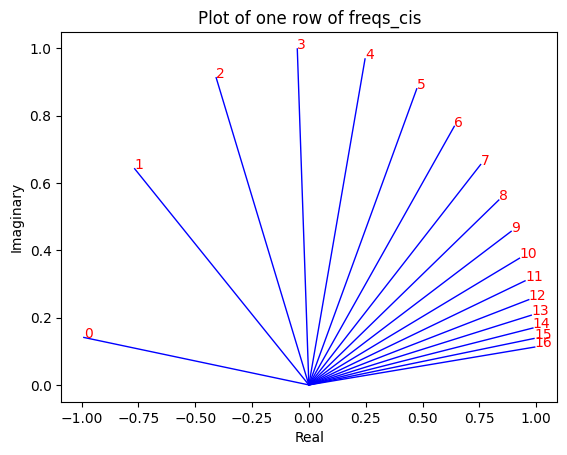

In [ ]:
q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2) # [17, 64, 2]
zero_to_one_split_into_64_parts = torch.tensor(range(head_dim//2))/(64) # head_dim // 2 = 64
print("zero_to_one_split_into_64_parts\n",zero_to_one_split_into_64_parts)
print("="*100)

freqs = 1.0 / (rope_theta ** zero_to_one_split_into_64_parts)
print("freqs\n",freqs)
print("="*100)

freqs_for_each_token = torch.outer(torch.arange(seq_len), freqs)
freqs_cis = torch.polar(torch.ones_like(freqs_for_each_token), freqs_for_each_token)
print("freqs_cis\n",freqs_cis)
print("="*100)


# viewing the third row of freqs_cis
value = freqs_cis[3]
plt.figure()
for i, element in enumerate(value[:seq_len]):
    plt.plot([0, element.real], [0, element.imag], color='blue', linewidth=1, label=f"Index: {i}")
    plt.annotate(f"{i}", xy=(element.real, element.imag), color='red')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Plot of one row of freqs_cis')
plt.show()

#### now that we have a complex number (the angle change vector) for every token's query element

> we can convert our queries (the one we split into pairs) as complex numbers and then dot product to rotate the query based on the position : q_per_token_as_complex_numbers & q_per_token_as_complex_numbers_rotated [17, 64]

> we can get back our the queries as pairs by viewing the complex numbers as real numbers again : q_per_token_split_into_pairs_rotated [17, 64, 2]

> the rotated pairs are now merged, we now have a new query vector (rotated query vector) that is of the shape [17x128] where 17 is the number of tokens and the 128 is the dim of the query vector : q_per_token_rotated [17, 128]

In [ ]:
q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs) # [17, 64]
print("q_per_token_as_complex_numbers\n",q_per_token_as_complex_numbers)
print("="*100)

q_per_token_as_complex_numbers_rotated = q_per_token_as_complex_numbers * freqs_cis        # [17, 64]
print("q_per_token_as_complex_numbers_rotated\n",q_per_token_as_complex_numbers_rotated)
print("="*100)

q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers_rotated) # [17, 64, 2]
print("q_per_token_split_into_pairs_rotated\n",q_per_token_split_into_pairs_rotated)
print("="*100)

q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape) # [17, 128]
print("q_per_token_rotated\n",q_per_token_rotated)
print("="*100)

q_per_token_as_complex_numbers
 tensor([[-0.0757-0.1094j,  0.2734-0.2119j,  0.2656-0.3750j,  ...,
          0.1943-0.1729j,  0.1768+0.5117j,  0.1758+0.0845j],
        [ 0.1660-0.2773j,  0.3652-0.5156j,  0.3809-0.8008j,  ...,
          0.5859+0.0767j,  0.5156+0.6875j,  0.5156+0.6562j],
        [ 1.0781+0.0549j,  2.4844-1.3906j,  1.8594-2.1719j,  ...,
          0.4629-0.5898j,  0.3086+1.4453j,  0.8086+0.3066j],
        ...,
        [ 1.1406+0.1196j,  2.6250-1.1953j,  1.7422-2.2031j,  ...,
          0.4492-0.1885j, -0.0052+1.6484j,  0.5664+0.0273j],
        [ 0.7266+0.1553j,  2.3125-0.9844j,  1.6250-2.1875j,  ...,
          0.6719-0.4746j,  0.7500+1.1875j,  0.4863+0.0140j],
        [ 0.6445-0.0413j,  1.5312-0.9570j,  1.1562-1.6250j,  ...,
          0.3926-0.4727j,  0.5391+1.1719j,  0.6875+0.2598j]],
       grad_fn=<ViewAsComplexBackward0>)
q_per_token_as_complex_numbers_rotated
 tensor([[-0.0757-0.1094j,  0.2734-0.2119j,  0.2656-0.3750j,  ...,
          0.1943-0.1729j,  0.1768+0.5117j,  0

### same for keys

In [ ]:
k_layer0 = model["layers.0.attention.wk.weight"]
k_layer0 = k_layer0.view(n_kv_heads, k_layer0.shape[0] // n_kv_heads, embed_dim) # [8, 128, 4096]
k_layer0_head0 = k_layer0[0]                                     # [128, 4096]
k_per_token = torch.matmul(token_embeddings, k_layer0_head0.T)    # [17, 128]
k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2) # [17, 64, 2]
k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)  # [17, 64]
k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis) # [17, 64, 2]
k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape) # [17, 128]
k_per_token_rotated

tensor([[ 0.5078, -0.3242,  0.9375,  ..., -0.2080,  0.0583,  0.2412],
        [ 0.8619,  6.8369, -0.6786,  ..., -1.4531, -1.2734, -1.0547],
        [-4.7781,  4.9960, -2.8142,  ..., -1.0625, -1.1953, -0.8281],
        ...,
        [-1.4398,  7.7383,  3.6386,  ..., -0.7618, -1.4843, -1.1641],
        [-4.5773,  2.1493,  3.6660,  ..., -1.4531, -0.9414, -1.1250],
        [-2.6795, -1.5071,  1.6741,  ..., -0.7500, -0.6328, -1.0469]],
       grad_fn=<ViewBackward0>)

### at this stage now have both the rotated values of queries and keys, for each token

> doing this will give us a score mapping each token with one another

> this score describes how well each token's query relates to the each tokens's key. THIS IS SELF ATTENTION :)

> the shape of the attention score matrix (qk_per_token) is [17x17] where 17 is the number of tokens in the promptoing this will give us a score mapping each token with one another

we now have to mask query key scores

during the training process of llama3, the future token qk scores are masked.
why? because during training we only learn to predict tokens using past tokens.
as a result, during inference we set the future tokens to zero.we now have to mask query key scores



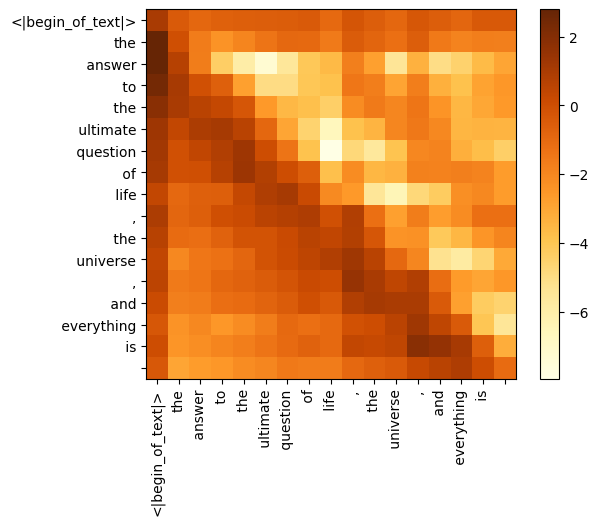

In [ ]:
qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(head_dim)**0.5

def display_qk_heatmap(qk_per_token):
    _, ax = plt.subplots()
    im = ax.imshow(qk_per_token.to(float).detach(), cmap='YlOrBr')
    ax.set_xticks(range(len(prompt_split_as_tokens)))
    ax.set_yticks(range(len(prompt_split_as_tokens)))
    ax.set_xticklabels(prompt_split_as_tokens)
    ax.set_xticklabels(prompt_split_as_tokens, rotation=90)
    ax.set_yticklabels(prompt_split_as_tokens)
    ax.figure.colorbar(im, ax=ax)

display_qk_heatmap(qk_per_token)

In [ ]:
mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
mask = torch.triu(mask, diagonal=1) # [17, 17]
mask

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -in

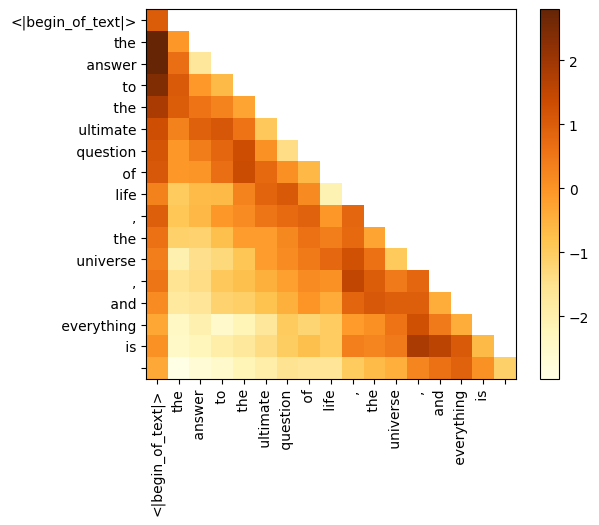

In [ ]:
qk_per_token_after_masking = qk_per_token + mask
display_qk_heatmap(qk_per_token_after_masking)

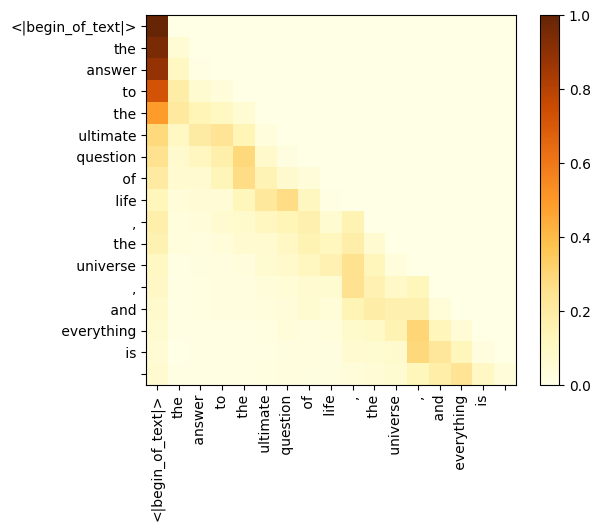

In [ ]:
qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
display_qk_heatmap(qk_per_token_after_masking_after_softmax)

### values (almost the end of attention)

> these scores (0-1) are used to determine how much of value matrix is used per token

> just like keys, value weights are also shared acorss every 4 attention heads (to save computation)

> as a result, the shape of the value weight matrix below is [8x128x4096]

> the first layer, first head value weight matrix is given below [128x4096]

> we now use the value weghts to get the attention values per token, this is of size [17x128] where 17 is the number of tokens in the prompt and 128 is the dim of the value vector per token

> the resultant attention vector after multipying with the values per token is of shape [17x128]

In [ ]:
v_layer0 = model["layers.0.attention.wv.weight"]
v_layer0 = v_layer0.view(n_kv_heads, v_layer0.shape[0] // n_kv_heads, embed_dim) # [8x128x4096]
v_layer0_head0 = v_layer0[0]  # [128x4096]
v_per_token = torch.matmul(token_embeddings, v_layer0_head0.T) # [17x128]
qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token) # [17x128]
qkv_attention

tensor([[ 1.5442e-02,  8.0872e-04,  3.3447e-02,  ..., -2.4780e-02,
         -2.8076e-03,  6.4941e-02],
        [ 1.4648e-02,  3.4523e-04,  3.4424e-02,  ..., -2.3682e-02,
         -4.3335e-03,  5.7617e-02],
        [ 1.3733e-02, -9.0122e-05,  3.4912e-02,  ..., -2.2339e-02,
         -5.6152e-03,  4.9805e-02],
        ...,
        [-9.7656e-03, -6.4392e-03,  2.8320e-02,  ...,  7.1411e-03,
         -8.9722e-03,  1.9775e-02],
        [-8.6060e-03, -1.1215e-03,  2.7832e-02,  ...,  7.8125e-03,
         -1.2817e-02,  2.3682e-02],
        [ 4.6997e-03,  9.4414e-05,  2.3193e-02,  ...,  7.2861e-04,
         -1.2451e-02,  2.1362e-02]], dtype=torch.bfloat16,
       grad_fn=<MmBackward0>)

### Multi-head attention

> we now have a the qkv_attention matrix for all 32 heads on the first layer, next im going to merge all attention scores into one large matrix of size [17x4096]

> one of the last things to do for a layer 0 attention is, is to multiply the weight matrix of the [4096x4096]

> we now have the change in the embedding value after attention, that should be adding to the original token embeddings  [17x4096]

> we normalize and then run a feed forward neural network through the embedding delta


In [ ]:
qkv_attention_store = []

for head in range(n_heads):
    q_layer0_head = q_layer0[head]
    k_layer0_head = k_layer0[head//4] # key weights are shared across 4 heads
    v_layer0_head = v_layer0[head//4] # value weights are shared across 4 heads
    q_per_token = torch.matmul(token_embeddings, q_layer0_head.T)
    k_per_token = torch.matmul(token_embeddings, k_layer0_head.T)
    v_per_token = torch.matmul(token_embeddings, v_layer0_head.T)

    q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
    q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
    q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
    q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)

    k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
    k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
    k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
    k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)

    qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5
    mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
    mask = torch.triu(mask, diagonal=1)
    qk_per_token_after_masking = qk_per_token + mask
    qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
    qkv_attention_store.append(qkv_attention)

print(len(qkv_attention_store)) # 32
stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1) # [17x4096]
w_layer0 = model["layers.0.attention.wo.weight"]   # [4096x4096]
embedding_delta = torch.matmul(stacked_qkv_attention, w_layer0.T) # [17x4096]
embedding_after_edit = token_embeddings_unnormalized + embedding_delta  # [17x4096]
embedding_after_edit_normalized = rms_norm(embedding_after_edit, model["layers.0.ffn_norm.weight"]) # [17x4096]
embedding_after_edit_normalized.shape

32


torch.Size([17, 4096])

> loading the ff weights and implementing the feed forward network

in llama3, they used a SwiGLU feedforward network, this network architecture is really good at adding non linearity when needed by the model. [17x4096]

> Now that we've edited embedding as having information about all queries asked on the first layer now each layer will encode more and more complex queries on the quesions asked, until we have an embedding that knows everything about the next token that we need.

In [ ]:
w1 = model["layers.0.feed_forward.w1.weight"]
w2 = model["layers.0.feed_forward.w2.weight"]
w3 = model["layers.0.feed_forward.w3.weight"]
output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
layer_0_embedding = embedding_after_edit+output_after_feedforward # same as embedding_after_edit_normalized i.e [17, 4096]
layer_0_embedding.shape

torch.Size([17, 4096])

In [ ]:
down_cycled_n_layers = 32 # only works for 32 not less that that

In [ ]:
final_embedding = token_embeddings_unnormalized
for layer in range(down_cycled_n_layers):
    qkv_attention_store = []
    layer_embedding_norm = rms_norm(final_embedding, model[f"layers.{layer}.attention_norm.weight"])
    q_layer = model[f"layers.{layer}.attention.wq.weight"]
    q_layer = q_layer.view(n_heads, q_layer.shape[0] // n_heads, embed_dim)
    k_layer = model[f"layers.{layer}.attention.wk.weight"]
    k_layer = k_layer.view(n_kv_heads, k_layer.shape[0] // n_kv_heads, embed_dim)
    v_layer = model[f"layers.{layer}.attention.wv.weight"]
    v_layer = v_layer.view(n_kv_heads, v_layer.shape[0] // n_kv_heads, embed_dim)
    w_layer = model[f"layers.{layer}.attention.wo.weight"]
    for head in range(n_heads):
        q_layer_head = q_layer[head]
        k_layer_head = k_layer[head//4]
        v_layer_head = v_layer[head//4]
        q_per_token = torch.matmul(layer_embedding_norm, q_layer_head.T)
        k_per_token = torch.matmul(layer_embedding_norm, k_layer_head.T)
        v_per_token = torch.matmul(layer_embedding_norm, v_layer_head.T)
        q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
        q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
        q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis)
        q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
        k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
        k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
        k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis)
        k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)
        qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5
        mask = torch.full((len(token_embeddings_unnormalized), len(token_embeddings_unnormalized)), float("-inf"))
        mask = torch.triu(mask, diagonal=1)
        qk_per_token_after_masking = qk_per_token + mask
        qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
        qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
        qkv_attention_store.append(qkv_attention)

    stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
    w_layer = model[f"layers.{layer}.attention.wo.weight"]
    embedding_delta = torch.matmul(stacked_qkv_attention, w_layer.T)
    embedding_after_edit = final_embedding + embedding_delta
    embedding_after_edit_normalized = rms_norm(embedding_after_edit, model[f"layers.{layer}.ffn_norm.weight"])
    w1 = model[f"layers.{layer}.feed_forward.w1.weight"]
    w2 = model[f"layers.{layer}.feed_forward.w2.weight"]
    w3 = model[f"layers.{layer}.feed_forward.w3.weight"]
    output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
    final_embedding = embedding_after_edit+output_after_feedforward

final_embedding.shape

torch.Size([17, 4096])

> now have the final embedding, the best guess the model could make about the next token

> we will use the output decoder to convert the final embedding into a token

In [ ]:
final_embedding = rms_norm(final_embedding, model["norm.weight"]) # [17x4096]
print(model["output.weight"].shape)    # [128256x4096]
logits = torch.matmul(final_embedding[-1], model["output.weight"].T) # [128256]
logits

torch.Size([128256, 4096])


tensor([ 1.3359, -1.5859, -0.1104,  ..., -4.2500, -4.2500, -4.2500],
       dtype=torch.bfloat16, grad_fn=<SqueezeBackward4>)


we use the embedding of the last token to predict the next value

hopefully in our case, 42 :) note: 42 is the answer to "the answer to the ultimate question of life, the universe, and everything is ", according to the book "hitchhiker's guide to the galaxy", most mordern llms would answer with 42 here, which should validate our entire code!  :)


the model predicted token number 2983 as the next token, is this the token number for 42?


In [ ]:
logits = torch.matmul(final_embedding[-1], model["output.weight"].T)  # [128256]
next_token = torch.argmax(logits, dim=-1)
print(tokenizer.decode([next_token.item()]))


42


## Testing standalone Ateention mechanism

In [ ]:
model_parallel_size = 2 # I've 2XT4 GPU
n_local_heads = n_heads // model_parallel_size
n_local_kv_heads = n_kv_heads // model_parallel_size
n_rep = n_local_heads // n_local_kv_heads
head_dim = embed_dim // n_heads

    LlamaSdpaAttention(
      (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
      (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
      (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
      (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
      (rotary_emb): LlamaRotaryEmbedding()
    )


In [ ]:
# Extract the attention layer
attention_layer = model.model.layers[0].self_attn

num_heads = 8 # number_attn_heads
batch_size = embed_input.size(0)
seq_len = embed_input.size(1)
embed_dim = embed_input.size(2)
head_dim =  embed_dim// num_heads
# Shape: [batch_size, seq_len]
position_ids = torch.arange(seq_len).unsqueeze(0).expand(batch_size, -1).to(embed_input.device)
# Adjusted to shape [seq_len, head_dim]
freqs_cis = torch.ones(seq_len, head_dim).to(embed_input.device)


# Prepare attention mask
attention_mask = inputs["attention_mask"]
attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)  # Shape: [batch_sz, 1, 1, seq_len]
attention_mask = attention_mask.to(torch.bool)  # Ensure mask is of boolean type

# Call the forward method of the attention layer
with torch.no_grad():
    # Adjust the call to match the attention layer's expected arguments
    attn_output = attention_layer(
        hidden_states=embed_input,
        attention_mask=attention_mask,
        position_ids=position_ids,
        output_attentions=True  # To get attention weights
    )

# Print the results
print("Hidden States [batch_sz,seq,embed_dim]:", embed_input.size())
print("Attention Output [batch_sz,seq,embed_dim]:", attn_output[0].size())  # Output is a tuple (attn_output, attention_weights)
print("Attention Weights [batch_sz,n_heads,q_len,k_len]:", attn_output[1].size())  # Assuming output_attentions=True returns attention weights

AttributeError: 'dict' object has no attribute 'model'

In [ ]:
# Run a forward pass
outputs = model(**inputs)
hidden_states = outputs.hidden_states
attentions = outputs.attentions

print("\nHidden States:", len(hidden_states))
for i, state in enumerate(hidden_states):
    print(f"Layer {i} shape[batch_size,seq_len, embed_dim]: {state.shape}")
    break

print("\nAttention Weights:",len(attentions))
for i, attn in enumerate(attentions):
    print(f"Layer {i} shape [batch_size, num_heads, seq_len_q, seq_len_k]: {attn.shape}")
    break

# Extracting output using hookmodel["output.weight"].shape

In [ ]:
model.eval()

# Define a hook function to capture rotary embeddings
def get_rotary_embeddings_hook(module, input_x, output):
    global rotary_embeddings
    # rotary embeddings are calculated inside the forward method
    # input_x : [[batch_sz,n_heads,seq_len,head_dim],[batch_sz,seq_len]],rotary embeddings are applied to xq and xk,
    print(f"Shape of input_x: {[x.shape for x in input_x]}")
    rotary_embeddings = input_x[0]  # Adjust based on the actual input tensor



def register_rotary_embed_hooks(model):
    for name, module in model.named_modules():
        # 1st layer -> self_attn -> rotary_embed (apply freqs_cis)
        attn_layer_0_rotary = module.model.layers[0].self_attn.rotary_emb
        attn_layer_0_rotary.register_forward_hook(get_rotary_embeddings_hook)
        break

register_rotary_embed_hooks(model)

with torch.no_grad():
    _ = model(**inputs)

# Print the captured rotary embeddings
print("\nRotary Embeddings Shape[batch_sz,seq_len]:", rotary_embeddings.shape)

In [ ]:
# Define a hook function to capture MLP outputs
def get_mlp_outputs_hook(module, input_x, output):
    # Hook function to save MLP outputs
    global mlp_outputs
    mlp_outputs = output  # This captures the output of the MLP layer


def register_mlp_hooks(model):
    for name, module in model.named_modules():
        # 1st layer -> mlp (apply freqs_cis)
        layer_mlp = module.model.layers[0].mlp
        layer_mlp.register_forward_hook(get_mlp_outputs_hook)
        break

register_mlp_hooks(model)

with torch.no_grad():
    _ = model(**inputs)

# Print the captured MLP outputs
print("\nMLP Outputs Shape[batch_sz,seq_len,embed_dim]:", mlp_outputs.shape)

In [ ]:
#